# 가위바위보 분류기 만들기

In [1]:
from PIL import Image
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

## 1. 데이터 준비

### 1-1. 이미지 사이즈 조절

In [2]:
# 이미지 사이즈 조절하는 함수 정의
def image_resize(rsp):
    # 이미지가 저장된 디렉토리 아래의 모든 jpg 파일 읽어오기
    image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/" + rsp
    print("이미지 디렉토리 경로: ", image_dir_path)

    images=glob.glob(image_dir_path + "/*.jpg")  

    # 이미지 사이즈를 모두 28x28로 변경하고 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img,"JPEG")

    print(rsp,  "image resize complete!")

# 가위, 바위, 보 디렉토리에 각각 함수 실행
image_resize(rsp="rock")
image_resize(rsp="scissor")
image_resize(rsp="paper")

이미지 디렉토리 경로:  /home/ssac21/aiffel/rock_scissor_paper/rock
rock image resize complete!
이미지 디렉토리 경로:  /home/ssac21/aiffel/rock_scissor_paper/scissor
scissor image resize complete!
이미지 디렉토리 경로:  /home/ssac21/aiffel/rock_scissor_paper/paper
paper image resize complete!


### 1-2. train data 불러오기

In [3]:
# 데이터 불러오는 함수 정의
def load_data(img_path, number_of_data):
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("이미지 개수는 %d개 입니다." % idx)
    return imgs, labels

이미지 개수는 4500개 입니다.
x_train shape: (4500, 28, 28, 3)
y_train shape: (4500,)

라벨:  0


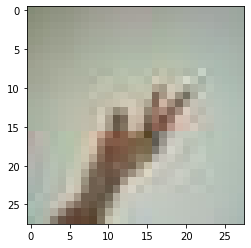

In [4]:
# train data 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path, 4500)  # 가위바위보 이미지 개수 총합에 주의
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

# 데이터 shape 확인
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

# 데이터 1개 출력해서 확인
plt.imshow(x_train[0])
print('\n라벨: ', y_train[0])

## 2. 딥러닝 모델 생성 및 훈련

In [5]:
# model 생성
tf.random.set_seed(1234)  # 동일한 결과를 보장하기 위해 seed 고정
model=keras.models.Sequential() # ↓사용할 이미지 특징의 수        # ↓(28x28픽셀)x3(RGB)
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu')) # 사용할 이미지 특징의 수
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))    # 분류기에 사용될 뉴런의 수(알고리즘의 복잡도)
model.add(keras.layers.Dense(3, activation='softmax'))  # 3개의 class로 분류

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

# model 학습시키기
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)  # epochs=학습 반복 횟수

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (No

## 3. 모델 성능 테스트

### 3-1. test data 불러오기

이미지 개수는 300개 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)

라벨:  0


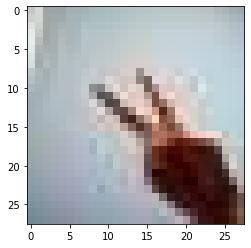

In [6]:
# 앞에서 생성한 load_data 함수로 test data 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_test"
(x_test, y_test)=load_data(image_dir_path, 300)  # 가위바위보 이미지 개수 총합에 주의
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

# 데이터 shape 확인
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

# 데이터 1개 출력해서 확인
plt.imshow(x_test[0])
print('\n라벨: ', y_test[0])

### 3-2. 모델 테스트

In [7]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 2s - loss: 1.1023 - accuracy: 0.7767
test_loss: 1.102266788482666 
test_accuracy: 0.7766666412353516


***
# 프로젝트 정리
## 1. 데이터 준비
- 노드에는 가위, 바위, 보 이미지를 각각 resize 하도록 코드가 분리되어 있었는데, 어차피 반복되는 코드라 함수로 만들었다. rock, scissor, paper에 해당하는 디렉토리명을 파라미터로 받는 image_resize 함수를 만들어 사용하니 코드가 간결해졌다.
- train data를 불러오는 load_data 함수도 나중에 test data를 불러올 때 재사용할 수 있도록 약간 수정했다. 원래는 number_of_data 값이 함수 내에 직접 지정되어 있었는데 이를 파라미터로 설정하여 변경 가능하도록 만들었다.

## 2. 딥러닝 모델 생성 및 훈련
- 노드에 나온 MNIST 예제 코드를 활용했고, 이미지가 28x28 사이즈의 컬러(RGB) 이미지이므로 input_shape를 (28,28,3)으로 설정했다. 그리고 3개의 클래스로 분류해야 하므로 마지막 Dense 레이어의 값을 3으로 설정했다.

## 3. 모델 성능 테스트
- 처음에 본인 이미지 300장으로 학습시키고 다른 사람 이미지 300장으로 테스트해본 결과 정확도가 0.3정도 나왔다. 1/3이니 거의 찍어서 맞추는 수준이었다...

## 4. 모델 성능 개선
- **train data 늘리기**: 우선 train data 300장은 너무 적은 것 같았다. 사진을 더 찍어서 데이터를 늘리는 방법을 고려해보았으나, 내가 찍은 사진은 어차피 비슷비슷할 것이므로 별 의미가 없을 것 같았다. 그래서 슬랙에 올라온 다른 분들의 데이터를 모아 900장, 1200장, 1500장, 이런 식으로 늘려가며 학습시켰다. 데이터 수가 늘어날 수록 확실히 정확도가 높아졌으나, 어느 정도부터는 0.5~0.7 수준에 정체되어서 총 4500장 선에서 마무리했다.
- **test data 재선정**: 만든 사람에 따라 이미지에 차이가 있기 때문에 최대한 손이 잘 나온 사진을 찾으려 했다. 내가 찍은 사진이 나름 흰 배경에 손 모양이 잘 보이도록 나와서 test data로 선정했다.
- **하이퍼파라미터 튜닝**: Conv2D 레이어의 이미지 특징 수, Dense 레이어의 뉴런 수, 학습의 epoch 값을 바꿔보며 테스트를 반복해보았다. 정확한 결과 비교를 위해서는 모델이 난수의 영향을 받으면 안되므로 set_seed를 사용해 고정시켰다.

## 5. 결과
위 실행화면에 약 78%의 정확도가 나온 최선의 결과를 기록했다. 조건을 정리해보면 다음과 같다
- 데이터
    - train: 다른 분들 이미지 4500개
    - test: 내 이미지 300개
- 하이퍼파라미터
    - 이미지 특징 수: 32, 64
    - 뉴런 수: 64
    - epoch: 10